In [1]:
# imports (add your imports here)
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt # for plotting
import pandas as pd

## Regression models

Preprocess the data for regression. Use the `Viability_at_time_of_observation_(%)` column as the label.

In [14]:
# data preprocessing code
# TODO
# your code here

# Reading in csv as dataframe
df = pd.read_csv('/content/Cell viability and extrusion dataset V1.csv')
df = df.drop(['Reference', 'DOI'], axis=1)

# Removing comment from numeric column
col_fix = "Fiber_Diameter_(µm)"
df[col_fix] = df[col_fix].str.replace(r' \(.*\)', "", regex=True).astype('float64')

# Handling null instances for temp
substrate_temp = 'Substrate_Temperature_(°C)'
syringe_temp = 'Syringe_Temperature_(°C)'
temp_list = [substrate_temp, syringe_temp]
df[temp_list] = df[temp_list].fillna(value=22)

# Removal of feature 50+% null or zero
row_count = df.shape[0]
columns_to_drop = []

# Loop over columns
for col in df.columns.values:

  # Get list of columns with at least half null or zero
  num_zero_na = sum((df[col] == 0) | (df[col].isna()))
  if num_zero_na / row_count >= 0.5:
    columns_to_drop.append(col)

# Drop the columns
df = df.drop(columns_to_drop, axis=1)

# Imputation of missing data using KNN
imputer = KNNImputer(n_neighbors=30)

# Get numeric columns
num_df = df.select_dtypes(include=[np.number])
num_cols = num_df.columns

# Impute and insert data into dataframe
imputed_data = imputer.fit_transform(num_df.to_numpy())
imputed_df = pd.DataFrame(imputed_data, columns=num_cols)
df[num_cols] = imputed_df

# One-Hot Encoding
cat_data_df = df.select_dtypes(exclude=[np.number])
cat_col_name = cat_data_df.columns
df_encoded = pd.get_dummies(df[cat_col_name], columns=cat_col_name, dtype=int)
df = pd.concat([df.drop(cat_col_name, axis=1), df_encoded], axis=1)

# Extract the features and labels
label_name = "Viability_at_time_of_observation_(%)"
x, y = df.drop([label_name], axis=1), df[label_name] # this is the x (features) and y (labels) of the data after preprocessing


Next, train your regression model within the following 5-fold cross validation code.

In [21]:
num_folds = 5

# Initialize lists to store training and test MSE for each fold
# TODO
mse_train_lst = []
mse_test_lst = []
r2_train_lst = []
r2_test_lst = []

# Create the KFold object
kf = KFold(n_splits=num_folds, shuffle=True)

# Loop over the folds
for train_index, test_index in kf.split(x):

    # Split the data into training and test sets for this fold
    x_fold_train=x.iloc[train_index]
    y_fold_train = y[train_index]
    x_fold_test=x.iloc[test_index]
    y_fold_test = y[test_index]

    # Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    x_fold_train = scaler.fit_transform(x_fold_train)
    x_fold_test = scaler.transform(x_fold_test)
    y_fold_train = scaler.fit_transform(y_fold_train.values.reshape(-1, 1))
    y_fold_train = np.ravel(y_fold_train)
    y_fold_test = scaler.transform(y_fold_test.values.reshape(-1, 1))
    y_fold_test = np.ravel(y_fold_test)

    # Train the model on the training set for this fold
    model = LinearRegression(fit_intercept=True) # your model here TODO

    model.fit(x_fold_train, y_fold_train)

    # Evaluate the model on the training set and test set for this fold
    train_pred = model.predict(x_fold_train)
    test_pred = model.predict(x_fold_test)

    # Record your train and test predictions
    # TODO

    # Calculate mse
    mse_train = mean_squared_error(y_fold_train, train_pred)
    mse_test = mean_squared_error(y_fold_test, test_pred)

    # Calculate r2
    r2_train = r2_score(y_fold_train, train_pred)
    r2_test = r2_score(y_fold_test, test_pred)

    # Save mse to list
    mse_train_lst.append(mse_train)
    mse_test_lst.append(mse_test)

    # Save r2 to list
    r2_train_lst.append(r2_train)
    r2_test_lst.append(r2_test)


For each fold, record the train and test performance of the model in an array. Use the `matplotlib` library to plot the average performance of the model (average across folds).



In [24]:
# TODO

# Turn of displaying plot
plt.ioff()

# Create subplots
figure, axis = plt.subplots(1, 2, figsize=(10,4))

# Add space between the subplots
plt.subplots_adjust(wspace=0.5)

# MSE Plot
# Get mean from data
train_mse_mean = np.mean(mse_train_lst)
test_mse_mean = np.mean(mse_test_lst)

print("MSE Train: %s" % train_mse_mean)
print("MSE Test: %s" % test_mse_mean)

# Plot MSE data
axis[0].errorbar(1, train_mse_mean, fmt='o', label='Train', color='blue', capsize=10)
axis[0].errorbar(2, test_mse_mean, fmt='o', label='Test', color='red', capsize=10)

# Move plot in a bit (looks nicer)
axis[0].set_xlim(0.7, 2.3)

# Add labels and title to MSE plot
axis[0].set_xticks([1, 2])
axis[0].set_xticklabels(['Train', 'Test'])
axis[0].set_ylabel('Mean Squared Error (MSE)')
axis[0].set_title('MSE for Train and Test Sets')

# R2 Plot
# Get mean from data
train_r2_mean = np.mean(r2_train_lst)
test_r2_mean = np.mean(r2_test_lst)

print("R2 Train: %s" % train_r2_mean)
print("R2 Test: %s" % test_r2_mean)

# Plot R2 data
axis[1].errorbar(1, train_r2_mean, fmt='o', label='Train', color='blue', capsize=10)
axis[1].errorbar(2, test_r2_mean, fmt='o', label='Test', color='red', capsize=10)

# Move plot in a bit (looks nicer)
axis[1].set_xlim(0.7, 2.3)

# Add labels and title to MSE plot
axis[1].set_xticks([1, 2])
axis[1].set_xticklabels(['Train', 'Test'])
axis[1].set_ylabel('Coefficient of Determination (R2)')
axis[1].set_title('R2 for Train and Test Sets')

MSE Train: 0.009772411377549388
MSE Test: 0.010392368327041244
R2 Train: 0.6890244717499854
R2 Test: 0.6699245532437811


Text(0.5, 1.0, 'R2 for Train and Test Sets')

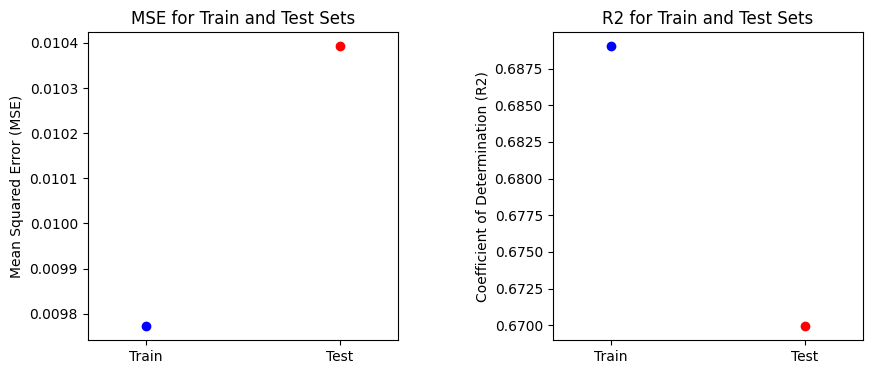

In [25]:
# plot your results here
plt.show()

## Classification models

Now, do the same thing with the three classification models. You can use nearly the same code to preprocess the data (this time, use the `Acceptable_Viability_(Yes/No)` column as your labels)

In [7]:
# data preprocessing code
# TODO
# your code here

# Reading in csv as dataframe
df = pd.read_csv('/content/Cell viability and extrusion dataset V1.csv')
df = df.drop(['Reference', 'DOI'], axis=1)

# Removing comment from numeric column
col_fix = "Fiber_Diameter_(µm)"
df[col_fix] = df[col_fix].str.replace(r' \(.*\)', "", regex=True).astype('float64')

# Handling null instances for temp
substrate_temp = 'Substrate_Temperature_(°C)'
syringe_temp = 'Syringe_Temperature_(°C)'
temp_list = [substrate_temp, syringe_temp]
df[temp_list] = df[temp_list].fillna(value=22)

# Removal of feature 50+% null or zero
row_count = df.shape[0]
columns_to_drop = []

# Loop over columns
for col in df.columns.values:

  # Get list of columns with at least half null or zero
  num_zero_na = sum((df[col] == 0) | (df[col].isna()))
  if num_zero_na / row_count >= 0.5:
    columns_to_drop.append(col)

# Drop the columns
df = df.drop(columns_to_drop, axis=1)

# Imputation of missing data using KNN
imputer = KNNImputer(n_neighbors=30)

# Get numeric columns
num_df = df.select_dtypes(include=[np.number])
num_cols = num_df.columns

# Impute and insert data into dataframe
imputed_data = imputer.fit_transform(num_df.to_numpy())
imputed_df = pd.DataFrame(imputed_data, columns=num_cols)
df[num_cols] = imputed_df

# One-Hot Encoding
cat_data_df = df.select_dtypes(exclude=[np.number])
cat_col_name = cat_data_df.columns
df_encoded = pd.get_dummies(df[cat_col_name], columns=cat_col_name, dtype=int)
df = pd.concat([df.drop(cat_col_name, axis=1), df_encoded], axis=1)

# Extract the features and labels
label_name = ["Acceptable_Viability_(Yes/No)_Y","Acceptable_Viability_(Yes/No)_N", "Acceptable_Pressure_(Yes/No)_Y", "Acceptable_Pressure_(Yes/No)_N"]
x, y = df.drop(label_name, axis=1), df[label_name[0]] # this is the x (features) and y (labels) of the data after preprocessing

### Random Forest Clasification

In [8]:
# cross validation and training code

num_folds = 5

# Initialize lists to store training and test accuracy for each fold
rfc_accuracy_train = []
rfc_accuracy_test = []

# Create the KFold object
kf = KFold(n_splits=num_folds, shuffle=True)

# Loop over the folds
for train_index, test_index in kf.split(x):

    # Split the data into training and test sets for this fold
    x_fold_train=x.iloc[train_index]
    y_fold_train = y[train_index]
    x_fold_test=x.iloc[test_index]
    y_fold_test = y[test_index]

    # Train the model on the training set for this fold
    rfc_model = RandomForestClassifier()

    rfc_model.fit(x_fold_train, y_fold_train)

    # Evaluate the model on the training set and test set for this fold
    rfc_train_pred = rfc_model.predict(x_fold_train)
    rfc_test_pred = rfc_model.predict(x_fold_test)

    # Record your train and test predictions
    rfc_accuracy_train.append(accuracy_score(y_fold_train, rfc_train_pred))
    rfc_accuracy_test.append(accuracy_score(y_fold_test, rfc_test_pred))

### Logistic Regression Classification

In [9]:
# cross validation and training code

num_folds = 5

# Initialize lists to store training and test accuracy for each fold
lrc_accuracy_train = []
lrc_accuracy_test = []

# Create the KFold object
kf = KFold(n_splits=num_folds, shuffle=True)

# Loop over the folds
for train_index, test_index in kf.split(x):

    # Split the data into training and test sets for this fold
    x_fold_train=x.iloc[train_index]
    y_fold_train = y[train_index]
    x_fold_test=x.iloc[test_index]
    y_fold_test = y[test_index]

    # Normalize the data
    scaler = StandardScaler()
    x_train_normalised = scaler.fit_transform(x_fold_train)
    x_test_normalised = scaler.transform(x_fold_test)

    # Train the model on the training set for this fold
    lrc_model = LogisticRegression()

    lrc_model.fit(x_train_normalised, y_fold_train)

    # Evaluate the model on the training set and test set for this fold
    lrc_train_pred = lrc_model.predict(x_train_normalised)
    lrc_test_pred = lrc_model.predict(x_test_normalised)

    # Record your train and test predictions
    lrc_accuracy_train.append(accuracy_score(y_fold_train, lrc_train_pred))
    lrc_accuracy_test.append(accuracy_score(y_fold_test, lrc_test_pred))


### Support Vector Classification

In [10]:
# cross validation and training code

num_folds = 5

# Initialize lists to store training and test accuracy for each fold
svc_accuracy_train = []
svc_accuracy_test = []

# Create the KFold object
kf = KFold(n_splits=num_folds, shuffle=True)

# Loop over the folds
for train_index, test_index in kf.split(x):

    # Split the data into training and test sets for this fold
    x_fold_train=x.iloc[train_index]
    y_fold_train = y[train_index]
    x_fold_test=x.iloc[test_index]
    y_fold_test = y[test_index]

    # Train the model on the training set for this fold
    svc_model = SVC()

    svc_model.fit(x_fold_train, y_fold_train)

    # Evaluate the model on the training set and test set for this fold
    svc_train_pred = svc_model.predict(x_fold_train)
    svc_test_pred = svc_model.predict(x_fold_test)

    # Record your train and test predictions
    svc_accuracy_train.append(accuracy_score(y_fold_train, svc_train_pred))
    svc_accuracy_test.append(accuracy_score(y_fold_test, svc_test_pred))


### Plotting

In [12]:
# Turn of displaying plot
plt.ioff()

# Calculate rfc means
train_rfc_mean = np.mean(rfc_accuracy_train)
test_rfc_mean = np.mean(rfc_accuracy_test)

# Calculate lrc means
train_lrc_mean = np.mean(lrc_accuracy_train)
test_lrc_mean = np.mean(lrc_accuracy_train)

# Calculate svc means
train_svc_mean = np.mean(svc_accuracy_train)
test_svc_mean = np.mean(svc_accuracy_train)

# Print means (for visual check)
print("RFC Train: %s" % train_rfc_mean)
print("RFC Test: %s" % test_rfc_mean)
print("LRC Train: %s" % train_lrc_mean)
print("LRC Test: %s" % test_lrc_mean)
print("SVC Train: %s" % train_svc_mean)
print("SVC Test: %s" % test_svc_mean)

# Create a bar plot
labels = ['Random Forest', 'Logistic Regression', 'Support Vector']
train_means = [train_rfc_mean, train_lrc_mean, train_svc_mean]
test_means = [test_rfc_mean, test_lrc_mean, test_svc_mean]

# Label Location
x = np.arange(len(labels))

# Width of bars
width = 0.35

# Plot bars
fig, ax = plt.subplots()
bar1 = ax.bar(x - width/2, train_means, width, label='Train')
bar2 = ax.bar(x + width/2, test_means, width, label='Test')

# Add labels
ax.set_ylabel('Accuracy')
ax.set_title('Train and Test Accuracies for Classification Models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Show plot
plt.tight_layout()

RFC Train: 1.0
RFC Test: 0.9983870967741936
LRC Train: 0.9923011225989768
LRC Test: 0.9923011225989768
SVC Train: 0.6158863768877647
SVC Test: 0.6158863768877647


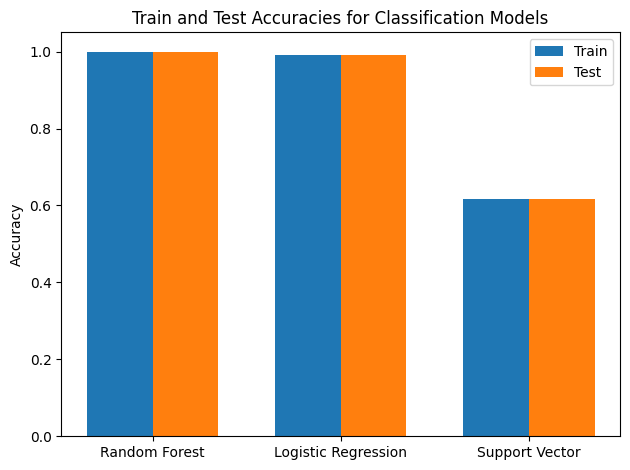

In [13]:
plt.show()